In [1]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'

/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Only extract hidden states
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[27].mean(dim=1).cpu().numpy())
    return np.vstack(hidden_states)

In [4]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:02<00:00,  3.72it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:20<00:00,  3.03it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4096 and hidden_dim=256


Training Epochs:   1%|          | 11/2000 [00:00<01:10, 28.14it/s]

Epoch 10/2000, Loss: 0.3914
Test Accuracy at Epoch 10: 70.53%
Test F1-score at Epoch 10: 0.7333
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       194
non_infringement       0.66      0.83      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380

New best model saved with F1-score 0.7333 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       194
non_infringement       0.66      0.83      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:   1%|          | 22/2000 [00:00<01:11, 27.83it/s]

Epoch 20/2000, Loss: 0.3030
Test Accuracy at Epoch 20: 73.16%
Test F1-score at Epoch 20: 0.7424
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380

New best model saved with F1-score 0.7424 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:   2%|▏         | 34/2000 [00:01<01:04, 30.29it/s]

Epoch 30/2000, Loss: 0.2487
Test Accuracy at Epoch 30: 74.21%
Test F1-score at Epoch 30: 0.7487
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.77      0.70      0.74       194
non_infringement       0.72      0.78      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

New best model saved with F1-score 0.7487 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.77      0.70      0.74       194
non_infringement       0.72      0.78      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:   2%|▏         | 46/2000 [00:01<01:02, 31.43it/s]

Epoch 40/2000, Loss: 0.2071
Test Accuracy at Epoch 40: 75.53%
Test F1-score at Epoch 40: 0.7466
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.75      0.77      0.76       194
non_infringement       0.76      0.74      0.75       186

        accuracy                           0.76       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:   3%|▎         | 54/2000 [00:01<01:03, 30.46it/s]

Epoch 50/2000, Loss: 0.1615
Test Accuracy at Epoch 50: 70.00%
Test F1-score at Epoch 50: 0.7273
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       194
non_infringement       0.66      0.82      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:   3%|▎         | 62/2000 [00:02<01:15, 25.71it/s]

Epoch 60/2000, Loss: 0.1443
Test Accuracy at Epoch 60: 73.16%
Test F1-score at Epoch 60: 0.7475
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:   4%|▎         | 73/2000 [00:02<01:14, 25.93it/s]

Epoch 70/2000, Loss: 0.1395
Test Accuracy at Epoch 70: 76.32%
Test F1-score at Epoch 70: 0.7581
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.77      0.77      0.77       194
non_infringement       0.76      0.76      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380

New best model saved with F1-score 0.7581 at epoch 70
Best Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.77      0.77      0.77       194
non_infringement       0.76      0.76      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:   4%|▍         | 81/2000 [00:02<01:05, 29.34it/s]

Epoch 80/2000, Loss: 0.1274
Test Accuracy at Epoch 80: 73.95%
Test F1-score at Epoch 80: 0.7468
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.77      0.70      0.73       194
non_infringement       0.71      0.78      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:   5%|▍         | 95/2000 [00:03<00:56, 33.87it/s]

Epoch 90/2000, Loss: 0.1261
Test Accuracy at Epoch 90: 71.58%
Test F1-score at Epoch 90: 0.7300
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.76      0.65      0.70       194
non_infringement       0.68      0.78      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.71       380
    weighted avg       0.72      0.72      0.71       380



Training Epochs:   5%|▌         | 103/2000 [00:03<01:01, 30.87it/s]

Epoch 100/2000, Loss: 0.1212
Test Accuracy at Epoch 100: 76.05%
Test F1-score at Epoch 100: 0.7624
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.78      0.74      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380

New best model saved with F1-score 0.7624 at epoch 100
Best Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.78      0.74      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:   6%|▌         | 111/2000 [00:03<01:05, 28.87it/s]

Epoch 110/2000, Loss: 0.1155
Test Accuracy at Epoch 110: 78.16%
Test F1-score at Epoch 110: 0.7787
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.79      0.78      0.78       194
non_infringement       0.77      0.78      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380

New best model saved with F1-score 0.7787 at epoch 110
Best Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.79      0.78      0.78       194
non_infringement       0.77      0.78      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:   6%|▋         | 127/2000 [00:04<01:00, 31.04it/s]

Epoch 120/2000, Loss: 0.1158
Test Accuracy at Epoch 120: 73.42%
Test F1-score at Epoch 120: 0.7430
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.72       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:   7%|▋         | 135/2000 [00:04<01:00, 30.89it/s]

Epoch 130/2000, Loss: 0.1149
Test Accuracy at Epoch 130: 77.89%
Test F1-score at Epoch 130: 0.7766
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.79      0.77      0.78       194
non_infringement       0.77      0.78      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:   7%|▋         | 146/2000 [00:04<00:47, 39.06it/s]

Epoch 140/2000, Loss: 0.1076
Test Accuracy at Epoch 140: 75.26%
Test F1-score at Epoch 140: 0.7565
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.78      0.72      0.75       194
non_infringement       0.73      0.78      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:   8%|▊         | 156/2000 [00:05<00:48, 37.99it/s]

Epoch 150/2000, Loss: 0.1059
Test Accuracy at Epoch 150: 75.00%
Test F1-score at Epoch 150: 0.7570
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.78      0.71      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:   8%|▊         | 161/2000 [00:05<00:46, 39.19it/s]

Epoch 160/2000, Loss: 0.1080
Test Accuracy at Epoch 160: 74.74%
Test F1-score at Epoch 160: 0.7551
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:   9%|▉         | 175/2000 [00:05<00:47, 38.60it/s]

Epoch 170/2000, Loss: 0.1080
Test Accuracy at Epoch 170: 75.79%
Test F1-score at Epoch 170: 0.7617
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.75       194
non_infringement       0.73      0.79      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:   9%|▉         | 185/2000 [00:05<00:48, 37.12it/s]

Epoch 180/2000, Loss: 0.1037
Test Accuracy at Epoch 180: 74.47%
Test F1-score at Epoch 180: 0.7519
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.72      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  10%|▉         | 195/2000 [00:06<00:48, 37.29it/s]

Epoch 190/2000, Loss: 0.1081
Test Accuracy at Epoch 190: 72.37%
Test F1-score at Epoch 190: 0.7382
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  10%|█         | 205/2000 [00:06<00:43, 41.51it/s]

Epoch 200/2000, Loss: 0.1022
Test Accuracy at Epoch 200: 74.47%
Test F1-score at Epoch 200: 0.7532
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  11%|█         | 215/2000 [00:06<00:44, 39.68it/s]

Epoch 210/2000, Loss: 0.1011
Test Accuracy at Epoch 210: 74.74%
Test F1-score at Epoch 210: 0.7551
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  11%|█▏        | 225/2000 [00:07<00:48, 36.90it/s]

Epoch 220/2000, Loss: 0.1004
Test Accuracy at Epoch 220: 75.26%
Test F1-score at Epoch 220: 0.7577
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.78      0.72      0.75       194
non_infringement       0.73      0.79      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  12%|█▏        | 236/2000 [00:07<00:42, 41.93it/s]

Epoch 230/2000, Loss: 0.1005
Test Accuracy at Epoch 230: 74.21%
Test F1-score at Epoch 230: 0.7525
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  12%|█▏        | 246/2000 [00:07<00:45, 38.54it/s]

Epoch 240/2000, Loss: 0.0996
Test Accuracy at Epoch 240: 74.21%
Test F1-score at Epoch 240: 0.7525
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  13%|█▎        | 255/2000 [00:07<00:48, 35.80it/s]

Epoch 250/2000, Loss: 0.1012
Test Accuracy at Epoch 250: 77.11%
Test F1-score at Epoch 250: 0.7740
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.80      0.74      0.77       194
non_infringement       0.75      0.80      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  13%|█▎        | 265/2000 [00:08<00:44, 39.39it/s]

Epoch 260/2000, Loss: 0.0999
Test Accuracy at Epoch 260: 75.26%
Test F1-score at Epoch 260: 0.7602
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  14%|█▍        | 275/2000 [00:08<00:44, 39.15it/s]

Epoch 270/2000, Loss: 0.0989
Test Accuracy at Epoch 270: 75.26%
Test F1-score at Epoch 270: 0.7614
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  14%|█▍        | 285/2000 [00:08<00:40, 42.35it/s]

Epoch 280/2000, Loss: 0.0981
Test Accuracy at Epoch 280: 74.74%
Test F1-score at Epoch 280: 0.7563
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  15%|█▍        | 296/2000 [00:08<00:41, 41.41it/s]

Epoch 290/2000, Loss: 0.0975
Test Accuracy at Epoch 290: 75.53%
Test F1-score at Epoch 290: 0.7621
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.80      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  15%|█▌        | 301/2000 [00:08<00:46, 36.76it/s]

Epoch 300/2000, Loss: 0.0971
Test Accuracy at Epoch 300: 75.00%
Test F1-score at Epoch 300: 0.7583
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  16%|█▌        | 311/2000 [00:09<00:42, 39.86it/s]

Epoch 310/2000, Loss: 0.0967
Test Accuracy at Epoch 310: 75.53%
Test F1-score at Epoch 310: 0.7621
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.80      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  16%|█▋        | 326/2000 [00:09<00:42, 39.77it/s]

Epoch 320/2000, Loss: 0.0964
Test Accuracy at Epoch 320: 75.00%
Test F1-score at Epoch 320: 0.7595
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  17%|█▋        | 331/2000 [00:09<00:47, 35.49it/s]

Epoch 330/2000, Loss: 0.0995
Test Accuracy at Epoch 330: 76.32%
Test F1-score at Epoch 330: 0.7619
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.78      0.75      0.76       194
non_infringement       0.75      0.77      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  17%|█▋        | 346/2000 [00:10<00:40, 40.52it/s]

Epoch 340/2000, Loss: 0.1030
Test Accuracy at Epoch 340: 73.16%
Test F1-score at Epoch 340: 0.7475
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  18%|█▊        | 357/2000 [00:10<00:43, 37.65it/s]

Epoch 350/2000, Loss: 0.0981
Test Accuracy at Epoch 350: 73.16%
Test F1-score at Epoch 350: 0.7475
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  18%|█▊        | 368/2000 [00:10<00:39, 41.51it/s]

Epoch 360/2000, Loss: 0.0968
Test Accuracy at Epoch 360: 76.05%
Test F1-score at Epoch 360: 0.7684
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  19%|█▊        | 373/2000 [00:10<00:37, 42.85it/s]

Epoch 370/2000, Loss: 0.0961
Test Accuracy at Epoch 370: 75.00%
Test F1-score at Epoch 370: 0.7595
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  19%|█▉        | 384/2000 [00:11<00:41, 39.40it/s]

Epoch 380/2000, Loss: 0.0956
Test Accuracy at Epoch 380: 75.79%
Test F1-score at Epoch 380: 0.7653
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  20%|█▉        | 395/2000 [00:11<00:43, 37.18it/s]

Epoch 390/2000, Loss: 0.0953
Test Accuracy at Epoch 390: 75.53%
Test F1-score at Epoch 390: 0.7634
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  20%|██        | 406/2000 [00:11<00:37, 42.01it/s]

Epoch 400/2000, Loss: 0.0950
Test Accuracy at Epoch 400: 75.53%
Test F1-score at Epoch 400: 0.7634
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  21%|██        | 416/2000 [00:11<00:40, 39.55it/s]

Epoch 410/2000, Loss: 0.0948
Test Accuracy at Epoch 410: 75.00%
Test F1-score at Epoch 410: 0.7595
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  21%|██        | 421/2000 [00:12<00:39, 40.21it/s]

Epoch 420/2000, Loss: 0.0947
Test Accuracy at Epoch 420: 75.00%
Test F1-score at Epoch 420: 0.7595
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  22%|██▏       | 435/2000 [00:12<00:40, 38.58it/s]

Epoch 430/2000, Loss: 0.0945
Test Accuracy at Epoch 430: 75.00%
Test F1-score at Epoch 430: 0.7595
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  22%|██▏       | 448/2000 [00:12<00:39, 39.33it/s]

Epoch 440/2000, Loss: 0.0943
Test Accuracy at Epoch 440: 75.26%
Test F1-score at Epoch 440: 0.7614
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  23%|██▎       | 453/2000 [00:12<00:39, 38.80it/s]

Epoch 450/2000, Loss: 0.0942
Test Accuracy at Epoch 450: 75.53%
Test F1-score at Epoch 450: 0.7634
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  23%|██▎       | 466/2000 [00:13<00:38, 39.52it/s]

Epoch 460/2000, Loss: 0.0986
Test Accuracy at Epoch 460: 73.16%
Test F1-score at Epoch 460: 0.7475
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  24%|██▍       | 476/2000 [00:13<00:39, 39.06it/s]

Epoch 470/2000, Loss: 0.0979
Test Accuracy at Epoch 470: 73.68%
Test F1-score at Epoch 470: 0.7537
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.79      0.65      0.72       194
non_infringement       0.70      0.82      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  24%|██▍       | 485/2000 [00:13<00:42, 35.51it/s]

Epoch 480/2000, Loss: 0.0996
Test Accuracy at Epoch 480: 74.74%
Test F1-score at Epoch 480: 0.7538
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.78      0.71      0.74       194
non_infringement       0.72      0.79      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  25%|██▍       | 495/2000 [00:14<00:37, 40.62it/s]

Epoch 490/2000, Loss: 0.1018
Test Accuracy at Epoch 490: 75.26%
Test F1-score at Epoch 490: 0.7626
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  25%|██▌       | 505/2000 [00:14<00:38, 38.50it/s]

Epoch 500/2000, Loss: 0.0957
Test Accuracy at Epoch 500: 76.05%
Test F1-score at Epoch 500: 0.7708
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.73      0.82      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  26%|██▌       | 515/2000 [00:14<00:39, 37.56it/s]

Epoch 510/2000, Loss: 0.0958
Test Accuracy at Epoch 510: 75.26%
Test F1-score at Epoch 510: 0.7614
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  26%|██▋       | 526/2000 [00:14<00:35, 41.62it/s]

Epoch 520/2000, Loss: 0.0947
Test Accuracy at Epoch 520: 75.79%
Test F1-score at Epoch 520: 0.7653
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  27%|██▋       | 536/2000 [00:15<00:36, 40.02it/s]

Epoch 530/2000, Loss: 0.0942
Test Accuracy at Epoch 530: 75.79%
Test F1-score at Epoch 530: 0.7653
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  27%|██▋       | 546/2000 [00:15<00:35, 41.45it/s]

Epoch 540/2000, Loss: 0.0939
Test Accuracy at Epoch 540: 75.79%
Test F1-score at Epoch 540: 0.7653
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  28%|██▊       | 556/2000 [00:15<00:38, 37.63it/s]

Epoch 550/2000, Loss: 0.0938
Test Accuracy at Epoch 550: 75.53%
Test F1-score at Epoch 550: 0.7634
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  28%|██▊       | 566/2000 [00:15<00:36, 38.97it/s]

Epoch 560/2000, Loss: 0.0937
Test Accuracy at Epoch 560: 76.32%
Test F1-score at Epoch 560: 0.7692
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  29%|██▉       | 576/2000 [00:16<00:33, 42.28it/s]

Epoch 570/2000, Loss: 0.0936
Test Accuracy at Epoch 570: 76.32%
Test F1-score at Epoch 570: 0.7692
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  29%|██▉       | 586/2000 [00:16<00:38, 36.88it/s]

Epoch 580/2000, Loss: 0.0935
Test Accuracy at Epoch 580: 75.79%
Test F1-score at Epoch 580: 0.7653
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  30%|██▉       | 596/2000 [00:16<00:36, 38.06it/s]

Epoch 590/2000, Loss: 0.0935
Test Accuracy at Epoch 590: 75.53%
Test F1-score at Epoch 590: 0.7634
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  30%|███       | 606/2000 [00:16<00:33, 42.19it/s]

Epoch 600/2000, Loss: 0.0934
Test Accuracy at Epoch 600: 75.79%
Test F1-score at Epoch 600: 0.7653
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  31%|███       | 617/2000 [00:17<00:33, 41.74it/s]

Epoch 610/2000, Loss: 0.0934
Test Accuracy at Epoch 610: 75.79%
Test F1-score at Epoch 610: 0.7653
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  31%|███       | 622/2000 [00:17<00:32, 42.22it/s]

Epoch 620/2000, Loss: 0.0933
Test Accuracy at Epoch 620: 75.79%
Test F1-score at Epoch 620: 0.7653
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  32%|███▏      | 638/2000 [00:17<00:31, 43.43it/s]

Epoch 630/2000, Loss: 0.0933
Test Accuracy at Epoch 630: 75.79%
Test F1-score at Epoch 630: 0.7653
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  32%|███▏      | 648/2000 [00:17<00:32, 41.85it/s]

Epoch 640/2000, Loss: 0.0932
Test Accuracy at Epoch 640: 75.79%
Test F1-score at Epoch 640: 0.7653
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  33%|███▎      | 653/2000 [00:18<00:31, 42.89it/s]

Epoch 650/2000, Loss: 0.0932
Test Accuracy at Epoch 650: 76.32%
Test F1-score at Epoch 650: 0.7716
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.82      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  33%|███▎      | 669/2000 [00:18<00:30, 43.93it/s]

Epoch 660/2000, Loss: 0.0932
Test Accuracy at Epoch 660: 76.32%
Test F1-score at Epoch 660: 0.7716
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.82      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  34%|███▎      | 674/2000 [00:18<00:33, 39.02it/s]

Epoch 670/2000, Loss: 0.0933
Test Accuracy at Epoch 670: 75.79%
Test F1-score at Epoch 670: 0.7629
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.79      0.72      0.75       194
non_infringement       0.73      0.80      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  34%|███▍      | 686/2000 [00:18<00:29, 43.90it/s]

Epoch 680/2000, Loss: 0.1026
Test Accuracy at Epoch 680: 72.63%
Test F1-score at Epoch 680: 0.7512
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.80      0.61      0.70       194
non_infringement       0.68      0.84      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  35%|███▍      | 696/2000 [00:19<00:31, 41.92it/s]

Epoch 690/2000, Loss: 0.1044
Test Accuracy at Epoch 690: 73.68%
Test F1-score at Epoch 690: 0.7487
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.72       194
non_infringement       0.70      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  35%|███▌      | 706/2000 [00:19<00:33, 38.67it/s]

Epoch 700/2000, Loss: 0.0974
Test Accuracy at Epoch 700: 76.84%
Test F1-score at Epoch 700: 0.7766
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.81      0.72      0.76       194
non_infringement       0.74      0.82      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  36%|███▌      | 716/2000 [00:19<00:30, 42.03it/s]

Epoch 710/2000, Loss: 0.0947
Test Accuracy at Epoch 710: 76.05%
Test F1-score at Epoch 710: 0.7696
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.82      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  36%|███▌      | 721/2000 [00:19<00:34, 37.49it/s]

Epoch 720/2000, Loss: 0.0938
Test Accuracy at Epoch 720: 76.32%
Test F1-score at Epoch 720: 0.7716
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.82      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  37%|███▋      | 736/2000 [00:20<00:29, 42.60it/s]

Epoch 730/2000, Loss: 0.0935
Test Accuracy at Epoch 730: 76.58%
Test F1-score at Epoch 730: 0.7735
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.73      0.82      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  37%|███▋      | 746/2000 [00:20<00:30, 40.85it/s]

Epoch 740/2000, Loss: 0.0934
Test Accuracy at Epoch 740: 76.84%
Test F1-score at Epoch 740: 0.7755
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.82      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  38%|███▊      | 756/2000 [00:20<00:32, 37.84it/s]

Epoch 750/2000, Loss: 0.0933
Test Accuracy at Epoch 750: 76.84%
Test F1-score at Epoch 750: 0.7755
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.82      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  38%|███▊      | 766/2000 [00:20<00:29, 41.90it/s]

Epoch 760/2000, Loss: 0.0932
Test Accuracy at Epoch 760: 76.84%
Test F1-score at Epoch 760: 0.7755
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.82      0.78       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  39%|███▉      | 776/2000 [00:21<00:31, 39.42it/s]

Epoch 770/2000, Loss: 0.0931
Test Accuracy at Epoch 770: 76.32%
Test F1-score at Epoch 770: 0.7692
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  39%|███▉      | 786/2000 [00:21<00:31, 38.44it/s]

Epoch 780/2000, Loss: 0.0931
Test Accuracy at Epoch 780: 76.32%
Test F1-score at Epoch 780: 0.7692
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  40%|███▉      | 796/2000 [00:21<00:29, 41.13it/s]

Epoch 790/2000, Loss: 0.0931
Test Accuracy at Epoch 790: 75.53%
Test F1-score at Epoch 790: 0.7634
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  40%|████      | 806/2000 [00:21<00:30, 39.46it/s]

Epoch 800/2000, Loss: 0.0930
Test Accuracy at Epoch 800: 75.79%
Test F1-score at Epoch 800: 0.7653
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  41%|████      | 811/2000 [00:22<00:30, 39.33it/s]

Epoch 810/2000, Loss: 0.0930
Test Accuracy at Epoch 810: 76.32%
Test F1-score at Epoch 810: 0.7692
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  41%|████▏     | 825/2000 [00:22<00:30, 39.15it/s]

Epoch 820/2000, Loss: 0.0930
Test Accuracy at Epoch 820: 76.32%
Test F1-score at Epoch 820: 0.7692
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  42%|████▏     | 835/2000 [00:22<00:30, 38.60it/s]

Epoch 830/2000, Loss: 0.0930
Test Accuracy at Epoch 830: 75.79%
Test F1-score at Epoch 830: 0.7653
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  42%|████▏     | 843/2000 [00:22<00:36, 31.61it/s]

Epoch 840/2000, Loss: 0.0929
Test Accuracy at Epoch 840: 76.32%
Test F1-score at Epoch 840: 0.7692
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  43%|████▎     | 853/2000 [00:23<00:30, 37.39it/s]

Epoch 850/2000, Loss: 0.0929
Test Accuracy at Epoch 850: 76.32%
Test F1-score at Epoch 850: 0.7692
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  43%|████▎     | 864/2000 [00:23<00:29, 38.62it/s]

Epoch 860/2000, Loss: 0.0929
Test Accuracy at Epoch 860: 75.79%
Test F1-score at Epoch 860: 0.7653
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  44%|████▍     | 875/2000 [00:23<00:29, 37.61it/s]

Epoch 870/2000, Loss: 0.0929
Test Accuracy at Epoch 870: 76.32%
Test F1-score at Epoch 870: 0.7692
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  44%|████▍     | 886/2000 [00:24<00:26, 42.41it/s]

Epoch 880/2000, Loss: 0.0929
Test Accuracy at Epoch 880: 76.32%
Test F1-score at Epoch 880: 0.7692
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  45%|████▍     | 896/2000 [00:24<00:27, 40.39it/s]

Epoch 890/2000, Loss: 0.0928
Test Accuracy at Epoch 890: 75.79%
Test F1-score at Epoch 890: 0.7653
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  45%|████▌     | 907/2000 [00:24<00:24, 44.34it/s]

Epoch 900/2000, Loss: 0.0928
Test Accuracy at Epoch 900: 75.79%
Test F1-score at Epoch 900: 0.7653
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  46%|████▌     | 917/2000 [00:24<00:25, 42.37it/s]

Epoch 910/2000, Loss: 0.0928
Test Accuracy at Epoch 910: 75.79%
Test F1-score at Epoch 910: 0.7653
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  46%|████▌     | 922/2000 [00:24<00:25, 43.01it/s]

Epoch 920/2000, Loss: 0.0928
Test Accuracy at Epoch 920: 76.32%
Test F1-score at Epoch 920: 0.7692
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  47%|████▋     | 938/2000 [00:25<00:24, 43.67it/s]

Epoch 930/2000, Loss: 0.0928
Test Accuracy at Epoch 930: 76.32%
Test F1-score at Epoch 930: 0.7692
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  47%|████▋     | 943/2000 [00:25<00:27, 39.06it/s]

Epoch 940/2000, Loss: 0.0975
Test Accuracy at Epoch 940: 78.42%
Test F1-score at Epoch 940: 0.7853
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.80      0.76      0.78       194
non_infringement       0.77      0.81      0.79       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380

New best model saved with F1-score 0.7853 at epoch 940
Best Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.80      0.76      0.78       194
non_infringement       0.77      0.81      0.79       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  48%|████▊     | 954/2000 [00:25<00:24, 43.49it/s]

Epoch 950/2000, Loss: 0.1019
Test Accuracy at Epoch 950: 76.05%
Test F1-score at Epoch 950: 0.7684
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  48%|████▊     | 969/2000 [00:26<00:24, 42.92it/s]

Epoch 960/2000, Loss: 0.0961
Test Accuracy at Epoch 960: 76.32%
Test F1-score at Epoch 960: 0.7692
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  49%|████▊     | 974/2000 [00:26<00:26, 38.85it/s]

Epoch 970/2000, Loss: 0.0943
Test Accuracy at Epoch 970: 76.05%
Test F1-score at Epoch 970: 0.7673
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.79      0.72      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  49%|████▉     | 984/2000 [00:26<00:24, 41.45it/s]

Epoch 980/2000, Loss: 0.0938
Test Accuracy at Epoch 980: 76.58%
Test F1-score at Epoch 980: 0.7712
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.80      0.73      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  50%|████▉     | 994/2000 [00:26<00:26, 38.10it/s]

Epoch 990/2000, Loss: 0.0937
Test Accuracy at Epoch 990: 76.32%
Test F1-score at Epoch 990: 0.7704
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  50%|█████     | 1004/2000 [00:26<00:24, 41.07it/s]

Epoch 1000/2000, Loss: 0.0947
Test Accuracy at Epoch 1000: 76.58%
Test F1-score at Epoch 1000: 0.7724
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  51%|█████     | 1018/2000 [00:27<00:23, 41.01it/s]

Epoch 1010/2000, Loss: 0.0931
Test Accuracy at Epoch 1010: 76.32%
Test F1-score at Epoch 1010: 0.7692
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  51%|█████     | 1023/2000 [00:27<00:26, 36.67it/s]

Epoch 1020/2000, Loss: 0.0929
Test Accuracy at Epoch 1020: 75.79%
Test F1-score at Epoch 1020: 0.7653
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  52%|█████▏    | 1033/2000 [00:27<00:23, 40.83it/s]

Epoch 1030/2000, Loss: 0.0929
Test Accuracy at Epoch 1030: 76.32%
Test F1-score at Epoch 1030: 0.7704
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  52%|█████▏    | 1048/2000 [00:28<00:22, 41.51it/s]

Epoch 1040/2000, Loss: 0.0928
Test Accuracy at Epoch 1040: 75.53%
Test F1-score at Epoch 1040: 0.7634
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  53%|█████▎    | 1053/2000 [00:28<00:27, 34.27it/s]

Epoch 1050/2000, Loss: 0.0928
Test Accuracy at Epoch 1050: 76.32%
Test F1-score at Epoch 1050: 0.7704
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  53%|█████▎    | 1063/2000 [00:28<00:23, 39.38it/s]

Epoch 1060/2000, Loss: 0.0928
Test Accuracy at Epoch 1060: 76.58%
Test F1-score at Epoch 1060: 0.7724
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  54%|█████▍    | 1079/2000 [00:28<00:21, 42.49it/s]

Epoch 1070/2000, Loss: 0.0927
Test Accuracy at Epoch 1070: 75.79%
Test F1-score at Epoch 1070: 0.7665
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  54%|█████▍    | 1084/2000 [00:28<00:24, 37.86it/s]

Epoch 1080/2000, Loss: 0.0927
Test Accuracy at Epoch 1080: 76.32%
Test F1-score at Epoch 1080: 0.7704
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  55%|█████▍    | 1094/2000 [00:29<00:21, 41.29it/s]

Epoch 1090/2000, Loss: 0.0927
Test Accuracy at Epoch 1090: 76.58%
Test F1-score at Epoch 1090: 0.7724
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  55%|█████▌    | 1106/2000 [00:29<00:21, 42.32it/s]

Epoch 1100/2000, Loss: 0.0927
Test Accuracy at Epoch 1100: 76.32%
Test F1-score at Epoch 1100: 0.7704
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  56%|█████▌    | 1117/2000 [00:29<00:21, 41.22it/s]

Epoch 1110/2000, Loss: 0.0927
Test Accuracy at Epoch 1110: 76.58%
Test F1-score at Epoch 1110: 0.7724
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  56%|█████▋    | 1128/2000 [00:29<00:19, 44.46it/s]

Epoch 1120/2000, Loss: 0.0927
Test Accuracy at Epoch 1120: 76.58%
Test F1-score at Epoch 1120: 0.7724
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  57%|█████▋    | 1133/2000 [00:30<00:20, 42.89it/s]

Epoch 1130/2000, Loss: 0.0927
Test Accuracy at Epoch 1130: 76.58%
Test F1-score at Epoch 1130: 0.7724
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  57%|█████▋    | 1149/2000 [00:30<00:19, 44.51it/s]

Epoch 1140/2000, Loss: 0.0926
Test Accuracy at Epoch 1140: 76.58%
Test F1-score at Epoch 1140: 0.7724
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  58%|█████▊    | 1154/2000 [00:30<00:21, 38.70it/s]

Epoch 1150/2000, Loss: 0.0926
Test Accuracy at Epoch 1150: 75.79%
Test F1-score at Epoch 1150: 0.7665
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  58%|█████▊    | 1166/2000 [00:30<00:18, 43.98it/s]

Epoch 1160/2000, Loss: 0.0930
Test Accuracy at Epoch 1160: 75.26%
Test F1-score at Epoch 1160: 0.7626
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  59%|█████▉    | 1176/2000 [00:31<00:20, 41.10it/s]

Epoch 1170/2000, Loss: 0.0926
Test Accuracy at Epoch 1170: 76.32%
Test F1-score at Epoch 1170: 0.7704
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  59%|█████▉    | 1186/2000 [00:31<00:20, 39.55it/s]

Epoch 1180/2000, Loss: 0.0930
Test Accuracy at Epoch 1180: 76.32%
Test F1-score at Epoch 1180: 0.7704
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  60%|█████▉    | 1196/2000 [00:31<00:19, 42.29it/s]

Epoch 1190/2000, Loss: 0.0926
Test Accuracy at Epoch 1190: 75.79%
Test F1-score at Epoch 1190: 0.7665
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  60%|██████    | 1207/2000 [00:31<00:19, 41.25it/s]

Epoch 1200/2000, Loss: 0.0933
Test Accuracy at Epoch 1200: 76.32%
Test F1-score at Epoch 1200: 0.7704
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  61%|██████    | 1217/2000 [00:32<00:19, 39.83it/s]

Epoch 1210/2000, Loss: 0.0926
Test Accuracy at Epoch 1210: 75.53%
Test F1-score at Epoch 1210: 0.7646
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  61%|██████▏   | 1227/2000 [00:32<00:17, 43.50it/s]

Epoch 1220/2000, Loss: 0.0933
Test Accuracy at Epoch 1220: 75.53%
Test F1-score at Epoch 1220: 0.7646
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  62%|██████▏   | 1232/2000 [00:32<00:20, 37.83it/s]

Epoch 1230/2000, Loss: 0.0927
Test Accuracy at Epoch 1230: 76.32%
Test F1-score at Epoch 1230: 0.7704
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  62%|██████▏   | 1242/2000 [00:32<00:18, 41.64it/s]

Epoch 1240/2000, Loss: 0.1017
Test Accuracy at Epoch 1240: 78.16%
Test F1-score at Epoch 1240: 0.7844
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.81      0.75      0.78       194
non_infringement       0.76      0.81      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  63%|██████▎   | 1257/2000 [00:33<00:18, 39.92it/s]

Epoch 1250/2000, Loss: 0.1019
Test Accuracy at Epoch 1250: 78.16%
Test F1-score at Epoch 1250: 0.7833
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.80      0.76      0.78       194
non_infringement       0.76      0.81      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  63%|██████▎   | 1262/2000 [00:33<00:19, 36.94it/s]

Epoch 1260/2000, Loss: 0.0994
Test Accuracy at Epoch 1260: 73.95%
Test F1-score at Epoch 1260: 0.7455
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.77      0.70      0.73       194
non_infringement       0.71      0.78      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  64%|██████▎   | 1273/2000 [00:33<00:17, 42.04it/s]

Epoch 1270/2000, Loss: 0.1001
Test Accuracy at Epoch 1270: 75.53%
Test F1-score at Epoch 1270: 0.7681
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.81      0.69      0.74       194
non_infringement       0.72      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  64%|██████▍   | 1284/2000 [00:33<00:17, 41.00it/s]

Epoch 1280/2000, Loss: 0.0985
Test Accuracy at Epoch 1280: 75.00%
Test F1-score at Epoch 1280: 0.7677
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.82      0.66      0.73       194
non_infringement       0.70      0.84      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  65%|██████▍   | 1295/2000 [00:34<00:18, 37.71it/s]

Epoch 1290/2000, Loss: 0.1017
Test Accuracy at Epoch 1290: 75.00%
Test F1-score at Epoch 1290: 0.7532
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.75       194
non_infringement       0.73      0.78      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  65%|██████▌   | 1304/2000 [00:34<00:18, 37.98it/s]

Epoch 1300/2000, Loss: 0.1011
Test Accuracy at Epoch 1300: 72.89%
Test F1-score at Epoch 1300: 0.7431
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.78      0.66      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  66%|██████▌   | 1314/2000 [00:34<00:17, 39.34it/s]

Epoch 1310/2000, Loss: 0.0962
Test Accuracy at Epoch 1310: 76.58%
Test F1-score at Epoch 1310: 0.7712
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.80      0.73      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  66%|██████▋   | 1326/2000 [00:34<00:16, 40.12it/s]

Epoch 1320/2000, Loss: 0.0940
Test Accuracy at Epoch 1320: 75.53%
Test F1-score at Epoch 1320: 0.7681
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.81      0.69      0.74       194
non_infringement       0.72      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  67%|██████▋   | 1337/2000 [00:35<00:14, 44.25it/s]

Epoch 1330/2000, Loss: 0.0941
Test Accuracy at Epoch 1330: 76.58%
Test F1-score at Epoch 1330: 0.7712
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.80      0.73      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  67%|██████▋   | 1347/2000 [00:35<00:16, 40.76it/s]

Epoch 1340/2000, Loss: 0.0944
Test Accuracy at Epoch 1340: 75.00%
Test F1-score at Epoch 1340: 0.7643
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.80      0.68      0.73       194
non_infringement       0.71      0.83      0.76       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  68%|██████▊   | 1357/2000 [00:35<00:15, 42.73it/s]

Epoch 1350/2000, Loss: 0.0938
Test Accuracy at Epoch 1350: 75.53%
Test F1-score at Epoch 1350: 0.7681
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.81      0.69      0.74       194
non_infringement       0.72      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  68%|██████▊   | 1368/2000 [00:35<00:14, 42.17it/s]

Epoch 1360/2000, Loss: 0.0937
Test Accuracy at Epoch 1360: 76.58%
Test F1-score at Epoch 1360: 0.7712
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.80      0.73      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  69%|██████▊   | 1373/2000 [00:36<00:14, 43.38it/s]

Epoch 1370/2000, Loss: 0.0937
Test Accuracy at Epoch 1370: 76.58%
Test F1-score at Epoch 1370: 0.7712
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.80      0.73      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  69%|██████▉   | 1389/2000 [00:36<00:13, 45.55it/s]

Epoch 1380/2000, Loss: 0.0931
Test Accuracy at Epoch 1380: 76.05%
Test F1-score at Epoch 1380: 0.7673
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.79      0.72      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380

Epoch 1390/2000, Loss: 0.0927


Training Epochs:  70%|██████▉   | 1394/2000 [00:36<00:15, 40.09it/s]

Test Accuracy at Epoch 1390: 75.79%
Test F1-score at Epoch 1390: 0.7653
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  70%|███████   | 1406/2000 [00:36<00:13, 45.10it/s]

Epoch 1400/2000, Loss: 0.0927
Test Accuracy at Epoch 1400: 76.05%
Test F1-score at Epoch 1400: 0.7673
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.79      0.72      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  71%|███████   | 1417/2000 [00:37<00:13, 43.89it/s]

Epoch 1410/2000, Loss: 0.0926
Test Accuracy at Epoch 1410: 76.05%
Test F1-score at Epoch 1410: 0.7673
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.79      0.72      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  71%|███████   | 1422/2000 [00:37<00:13, 44.28it/s]

Epoch 1420/2000, Loss: 0.0926
Test Accuracy at Epoch 1420: 76.32%
Test F1-score at Epoch 1420: 0.7692
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  72%|███████▏  | 1439/2000 [00:37<00:12, 45.40it/s]

Epoch 1430/2000, Loss: 0.0925
Test Accuracy at Epoch 1430: 76.58%
Test F1-score at Epoch 1430: 0.7712
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.80      0.73      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  72%|███████▏  | 1444/2000 [00:37<00:12, 46.27it/s]

Epoch 1440/2000, Loss: 0.0925
Test Accuracy at Epoch 1440: 76.32%
Test F1-score at Epoch 1440: 0.7692
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  73%|███████▎  | 1454/2000 [00:37<00:12, 43.13it/s]

Epoch 1450/2000, Loss: 0.0925
Test Accuracy at Epoch 1450: 76.58%
Test F1-score at Epoch 1450: 0.7712
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.80      0.73      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380

Epoch 1460/2000, Loss: 0.0925
Test Accuracy at Epoch 1460: 76.58%
Test F1-score at Epoch 1460: 0.7724


Training Epochs:  73%|███████▎  | 1465/2000 [00:38<00:13, 40.25it/s]

Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  74%|███████▍  | 1476/2000 [00:38<00:11, 45.40it/s]

Epoch 1470/2000, Loss: 0.0925
Test Accuracy at Epoch 1470: 76.84%
Test F1-score at Epoch 1470: 0.7744
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.80      0.73      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  74%|███████▍  | 1487/2000 [00:38<00:11, 44.19it/s]

Epoch 1480/2000, Loss: 0.0924
Test Accuracy at Epoch 1480: 76.84%
Test F1-score at Epoch 1480: 0.7744
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.80      0.73      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  75%|███████▍  | 1497/2000 [00:38<00:10, 46.02it/s]

Epoch 1490/2000, Loss: 0.0924
Test Accuracy at Epoch 1490: 76.84%
Test F1-score at Epoch 1490: 0.7744
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.80      0.73      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  75%|███████▌  | 1508/2000 [00:39<00:10, 44.95it/s]

Epoch 1500/2000, Loss: 0.0924
Test Accuracy at Epoch 1500: 76.84%
Test F1-score at Epoch 1500: 0.7744
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.80      0.73      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380

Epoch 1510/2000, Loss: 0.0924


Training Epochs:  76%|███████▌  | 1513/2000 [00:39<00:10, 45.58it/s]

Test Accuracy at Epoch 1510: 76.84%
Test F1-score at Epoch 1510: 0.7744
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.80      0.73      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  76%|███████▋  | 1529/2000 [00:39<00:10, 47.08it/s]

Epoch 1520/2000, Loss: 0.0924
Test Accuracy at Epoch 1520: 76.84%
Test F1-score at Epoch 1520: 0.7744
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.80      0.73      0.76       194
non_infringement       0.74      0.81      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380

Epoch 1530/2000, Loss: 0.0924
Test Accuracy at Epoch 1530: 76.32%
Test F1-score at Epoch 1530: 0.7704


Training Epochs:  77%|███████▋  | 1534/2000 [00:39<00:11, 41.28it/s]

Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  77%|███████▋  | 1546/2000 [00:40<00:10, 44.99it/s]

Epoch 1540/2000, Loss: 0.0923
Test Accuracy at Epoch 1540: 76.32%
Test F1-score at Epoch 1540: 0.7704
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  78%|███████▊  | 1557/2000 [00:40<00:10, 43.32it/s]

Epoch 1550/2000, Loss: 0.0923
Test Accuracy at Epoch 1550: 76.32%
Test F1-score at Epoch 1550: 0.7704
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1560/2000, Loss: 0.0923


Training Epochs:  78%|███████▊  | 1567/2000 [00:40<00:10, 40.09it/s]

Test Accuracy at Epoch 1560: 76.32%
Test F1-score at Epoch 1560: 0.7704
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  79%|███████▉  | 1578/2000 [00:40<00:09, 44.95it/s]

Epoch 1570/2000, Loss: 0.0923
Test Accuracy at Epoch 1570: 76.05%
Test F1-score at Epoch 1570: 0.7684
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  79%|███████▉  | 1583/2000 [00:40<00:10, 38.98it/s]

Epoch 1580/2000, Loss: 0.0923
Test Accuracy at Epoch 1580: 76.05%
Test F1-score at Epoch 1580: 0.7684
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  80%|███████▉  | 1594/2000 [00:41<00:10, 38.85it/s]

Epoch 1590/2000, Loss: 0.0923
Test Accuracy at Epoch 1590: 76.05%
Test F1-score at Epoch 1590: 0.7684
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  80%|████████  | 1605/2000 [00:41<00:09, 41.26it/s]

Epoch 1600/2000, Loss: 0.0923
Test Accuracy at Epoch 1600: 75.53%
Test F1-score at Epoch 1600: 0.7646
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380

Epoch 1610/2000, Loss: 0.0923
Test Accuracy at Epoch 1610: 75.53%
Test F1-score at Epoch 1610: 0.7646
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  81%|████████▏ | 1627/2000 [00:42<00:08, 45.73it/s]

Epoch 1620/2000, Loss: 0.0923
Test Accuracy at Epoch 1620: 75.53%
Test F1-score at Epoch 1620: 0.7646
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.80      0.70      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380

Epoch 1630/2000, Loss: 0.0922
Test Accuracy at Epoch 1630: 74.74%
Test F1-score at Epoch 1630: 0.7588


Training Epochs:  82%|████████▏ | 1632/2000 [00:42<00:09, 40.49it/s]

Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  82%|████████▏ | 1644/2000 [00:42<00:07, 46.44it/s]

Epoch 1640/2000, Loss: 0.0949
Test Accuracy at Epoch 1640: 72.11%
Test F1-score at Epoch 1640: 0.7452
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.79      0.61      0.69       194
non_infringement       0.67      0.83      0.75       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 1650/2000, Loss: 0.0939


Training Epochs:  83%|████████▎ | 1655/2000 [00:42<00:07, 46.06it/s]

Test Accuracy at Epoch 1650: 74.21%
Test F1-score at Epoch 1650: 0.7598
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.80      0.65      0.72       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  83%|████████▎ | 1666/2000 [00:42<00:06, 48.82it/s]

Epoch 1660/2000, Loss: 0.0931
Test Accuracy at Epoch 1660: 75.26%
Test F1-score at Epoch 1660: 0.7673
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.81      0.68      0.74       194
non_infringement       0.71      0.83      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  84%|████████▍ | 1677/2000 [00:43<00:07, 44.08it/s]

Epoch 1670/2000, Loss: 0.0923
Test Accuracy at Epoch 1670: 75.26%
Test F1-score at Epoch 1670: 0.7673
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.81      0.68      0.74       194
non_infringement       0.71      0.83      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1680/2000, Loss: 0.0924


Training Epochs:  84%|████████▍ | 1687/2000 [00:43<00:07, 40.79it/s]

Test Accuracy at Epoch 1680: 74.47%
Test F1-score at Epoch 1680: 0.7617
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.81      0.66      0.73       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  85%|████████▍ | 1698/2000 [00:43<00:06, 46.22it/s]

Epoch 1690/2000, Loss: 0.0923
Test Accuracy at Epoch 1690: 74.47%
Test F1-score at Epoch 1690: 0.7617
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.81      0.66      0.73       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1700/2000, Loss: 0.0923
Test Accuracy at Epoch 1700: 75.26%
Test F1-score at Epoch 1700: 0.7673


Training Epochs:  85%|████████▌ | 1703/2000 [00:43<00:07, 41.75it/s]

Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.81      0.68      0.74       194
non_infringement       0.71      0.83      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  86%|████████▌ | 1719/2000 [00:44<00:06, 46.81it/s]

Epoch 1710/2000, Loss: 0.0922
Test Accuracy at Epoch 1710: 75.26%
Test F1-score at Epoch 1710: 0.7673
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.81      0.68      0.74       194
non_infringement       0.71      0.83      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  86%|████████▌ | 1724/2000 [00:44<00:06, 40.25it/s]

Epoch 1720/2000, Loss: 0.0922
Test Accuracy at Epoch 1720: 74.47%
Test F1-score at Epoch 1720: 0.7617
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.81      0.66      0.73       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  87%|████████▋ | 1736/2000 [00:44<00:05, 45.50it/s]

Epoch 1730/2000, Loss: 0.0922
Test Accuracy at Epoch 1730: 75.26%
Test F1-score at Epoch 1730: 0.7673
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.81      0.68      0.74       194
non_infringement       0.71      0.83      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  87%|████████▋ | 1747/2000 [00:44<00:05, 44.36it/s]

Epoch 1740/2000, Loss: 0.0922
Test Accuracy at Epoch 1740: 75.00%
Test F1-score at Epoch 1740: 0.7654
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.81      0.67      0.73       194
non_infringement       0.71      0.83      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1750/2000, Loss: 0.0922


Training Epochs:  88%|████████▊ | 1757/2000 [00:45<00:05, 41.20it/s]

Test Accuracy at Epoch 1750: 75.26%
Test F1-score at Epoch 1750: 0.7673
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.81      0.68      0.74       194
non_infringement       0.71      0.83      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  88%|████████▊ | 1768/2000 [00:45<00:05, 46.18it/s]

Epoch 1760/2000, Loss: 0.0922
Test Accuracy at Epoch 1760: 75.00%
Test F1-score at Epoch 1760: 0.7654
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.81      0.67      0.73       194
non_infringement       0.71      0.83      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

Epoch 1770/2000, Loss: 0.0922


Training Epochs:  89%|████████▊ | 1773/2000 [00:45<00:05, 41.26it/s]

Test Accuracy at Epoch 1770: 75.26%
Test F1-score at Epoch 1770: 0.7673
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.81      0.68      0.74       194
non_infringement       0.71      0.83      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  89%|████████▉ | 1784/2000 [00:45<00:04, 44.53it/s]

Epoch 1780/2000, Loss: 0.0922
Test Accuracy at Epoch 1780: 76.32%
Test F1-score at Epoch 1780: 0.7704
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  90%|████████▉ | 1794/2000 [00:45<00:04, 42.28it/s]

Epoch 1790/2000, Loss: 0.0922
Test Accuracy at Epoch 1790: 76.32%
Test F1-score at Epoch 1790: 0.7704
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  90%|█████████ | 1805/2000 [00:46<00:04, 40.01it/s]

Epoch 1800/2000, Loss: 0.0922
Test Accuracy at Epoch 1800: 76.32%
Test F1-score at Epoch 1800: 0.7704
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  91%|█████████ | 1816/2000 [00:46<00:03, 46.25it/s]

Epoch 1810/2000, Loss: 0.0922
Test Accuracy at Epoch 1810: 76.05%
Test F1-score at Epoch 1810: 0.7684
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380

Epoch 1820/2000, Loss: 0.0922
Test Accuracy at Epoch 1820: 76.05%
Test F1-score at Epoch 1820: 0.7684
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  92%|█████████▏| 1838/2000 [00:46<00:03, 48.00it/s]

Epoch 1830/2000, Loss: 0.0921
Test Accuracy at Epoch 1830: 76.05%
Test F1-score at Epoch 1830: 0.7684
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380

Epoch 1840/2000, Loss: 0.0921


Training Epochs:  92%|█████████▏| 1843/2000 [00:46<00:03, 42.23it/s]

Test Accuracy at Epoch 1840: 76.05%
Test F1-score at Epoch 1840: 0.7684
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  93%|█████████▎| 1854/2000 [00:47<00:03, 44.64it/s]

Epoch 1850/2000, Loss: 0.0921
Test Accuracy at Epoch 1850: 76.05%
Test F1-score at Epoch 1850: 0.7684
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  93%|█████████▎| 1864/2000 [00:47<00:03, 39.79it/s]

Epoch 1860/2000, Loss: 0.0921
Test Accuracy at Epoch 1860: 76.05%
Test F1-score at Epoch 1860: 0.7684
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  94%|█████████▍| 1875/2000 [00:47<00:03, 39.44it/s]

Epoch 1870/2000, Loss: 0.0921
Test Accuracy at Epoch 1870: 76.05%
Test F1-score at Epoch 1870: 0.7684
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  94%|█████████▍| 1886/2000 [00:47<00:02, 44.73it/s]

Epoch 1880/2000, Loss: 0.0921
Test Accuracy at Epoch 1880: 76.05%
Test F1-score at Epoch 1880: 0.7684
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380

Epoch 1890/2000, Loss: 0.0922


Training Epochs:  95%|█████████▍| 1896/2000 [00:48<00:02, 40.47it/s]

Test Accuracy at Epoch 1890: 76.05%
Test F1-score at Epoch 1890: 0.7684
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  95%|█████████▌| 1907/2000 [00:48<00:02, 45.43it/s]

Epoch 1900/2000, Loss: 0.0924
Test Accuracy at Epoch 1900: 75.00%
Test F1-score at Epoch 1900: 0.7583
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  96%|█████████▌| 1917/2000 [00:48<00:02, 40.58it/s]

Epoch 1910/2000, Loss: 0.1048
Test Accuracy at Epoch 1910: 76.32%
Test F1-score at Epoch 1910: 0.7704
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.80      0.72      0.76       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  96%|█████████▋| 1927/2000 [00:49<00:01, 39.69it/s]

Epoch 1920/2000, Loss: 0.1257
Test Accuracy at Epoch 1920: 71.32%
Test F1-score at Epoch 1920: 0.7124
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.73      0.70      0.71       194
non_infringement       0.70      0.73      0.71       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  97%|█████████▋| 1938/2000 [00:49<00:01, 45.27it/s]

Epoch 1930/2000, Loss: 0.0996
Test Accuracy at Epoch 1930: 73.95%
Test F1-score at Epoch 1930: 0.7455
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.77      0.70      0.73       194
non_infringement       0.71      0.78      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1940/2000, Loss: 0.0955


Training Epochs:  97%|█████████▋| 1943/2000 [00:49<00:01, 41.03it/s]

Test Accuracy at Epoch 1940: 76.05%
Test F1-score at Epoch 1940: 0.7731
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.81      0.69      0.75       194
non_infringement       0.72      0.83      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  98%|█████████▊| 1954/2000 [00:49<00:01, 45.23it/s]

Epoch 1950/2000, Loss: 0.0936
Test Accuracy at Epoch 1950: 76.58%
Test F1-score at Epoch 1950: 0.7835
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.84      0.67      0.74       194
non_infringement       0.72      0.87      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.77      0.76       380

Epoch 1960/2000, Loss: 0.0929


Training Epochs:  98%|█████████▊| 1965/2000 [00:49<00:00, 43.36it/s]

Test Accuracy at Epoch 1960: 76.32%
Test F1-score at Epoch 1960: 0.7761
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.82      0.69      0.75       194
non_infringement       0.72      0.84      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  99%|█████████▉| 1976/2000 [00:50<00:00, 45.97it/s]

Epoch 1970/2000, Loss: 0.0927
Test Accuracy at Epoch 1970: 75.53%
Test F1-score at Epoch 1970: 0.7634
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  99%|█████████▉| 1987/2000 [00:50<00:00, 43.78it/s]

Epoch 1980/2000, Loss: 0.0925
Test Accuracy at Epoch 1980: 75.00%
Test F1-score at Epoch 1980: 0.7595
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs: 100%|█████████▉| 1997/2000 [00:50<00:00, 40.95it/s]

Epoch 1990/2000, Loss: 0.0925
Test Accuracy at Epoch 1990: 75.53%
Test F1-score at Epoch 1990: 0.7634
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs: 100%|██████████| 2000/2000 [00:50<00:00, 39.46it/s]
/tmp/ipykernel_1811521/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_s

Epoch 2000/2000, Loss: 0.0924
Test Accuracy at Epoch 2000: 75.00%
Test F1-score at Epoch 2000: 0.7595
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



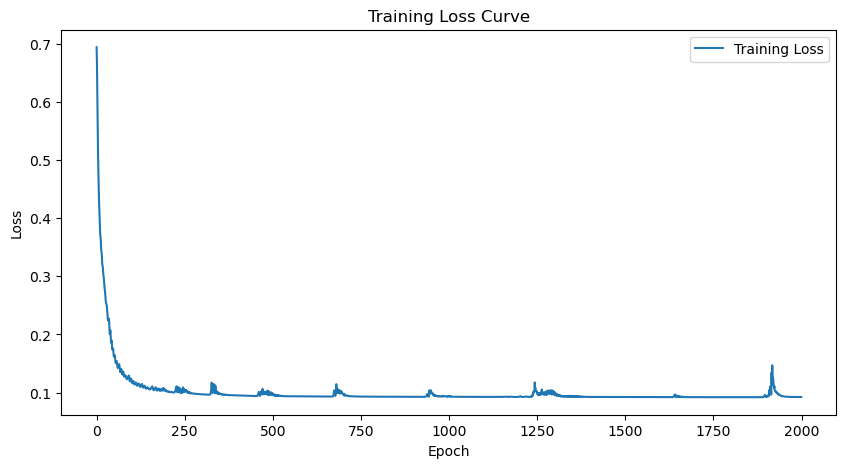

Final Model Accuracy: 78.42%
Final Model F1-score: 0.7853


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'.


In [11]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 78.42%
                  precision    recall  f1-score   support

    infringement       0.80      0.76      0.78       194
non_infringement       0.77      0.81      0.79       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



/tmp/ipykernel_1811521/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
